<a href="https://colab.research.google.com/github/wingated/cs474_labs_f2019/blob/master/DL_Lab4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Lab 4: Cancer Detection

## Objective
* To build a dense prediction model
* To begin reading current papers in DNN research

## Deliverable
For this lab, you will turn in a notebook that describes your efforts at creating
a pytorch radiologist. Your final deliverable is a notebook that has (1) a deep network,
(2) method of calculating accuracy, 
(3) images that show the dense prediction produced by your network on the pos_test_000072.png image (index 172 in the validation dataset).
This is an image in the test set that your network will not have seen before.
This image, and the ground truth labeling, is shown below.
(And is contained in the downloadable dataset below).

![](http://liftothers.org/dokuwiki/lib/exe/fetch.php?w=200&tok=a8ac31&media=cs501r_f2016:pos_test_000072_output.png)
<img src="http://liftothers.org/dokuwiki/lib/exe/fetch.php?media=cs501r_f2016:pos_test_000072.png" width="200">


## Grading standards
Your notebook will be graded on the following:
* 40% Proper design, creation and debugging of a dense prediction network
* 20% Proper implementation of train/test set accuracy measure
* 20% Tidy visualizations of loss of your dense predictor during training
* 20% Test image output


## Data set
The data is given as a set of 1024×1024 PNG images. Each input image (in 
the ```inputs``` directory) is an RGB image of a section of tissue,
and there a file with the same name (in the ```outputs``` directory) 
that has a dense labeling of whether or not a section of tissue is cancerous
(white pixels mean “cancerous”, while black pixels mean “not cancerous”).

The data has been pre-split for you into test and training splits.
Filenames also reflect whether or not the image has any cancer at all 
(files starting with ```pos_``` have some cancerous pixels, while files 
starting with ```neg_``` have no cancer anywhere).
All of the data is hand-labeled, so the dataset is not very large.
That means that overfitting is a real possibility.

## Description
For a video including some tips and tricks that can help with this lab: [https://youtu.be/Ms19kgK_D8w](https://youtu.be/Ms19kgK_D8w)
For this lab, you will implement a virtual radiologist.
You are given images of possibly cancerous tissue samples, 
and you must build a detector that identifies where in the tissue cancer may reside.

---

### Part 0
Watch and follow video tutorial:

https://youtu.be/Ms19kgK_D8w

**TODO:**

* Watch tutorial

**DONE:**

### Part 1
Implement a dense predictor

In previous labs and lectures, we have talked about DNNs that classify an 
entire image as a single class. Here, however, we are interested in a more nuanced classification: 
given an input image, we would like to identify each pixel that is possibly cancerous. 
That means that instead of a single output, your network should output an “image”, 
where each output pixel of your network represents the probability that a pixel is cancerous.

___

Implement your network topology

Use the “Deep Convolution U-Net” from this paper: [(U-Net: Convolutional Networks for Biomedical Image Segmentation)](https://arxiv.org/pdf/1505.04597.pdf) 

![(Figure 1)](https://lh3.googleusercontent.com/qnHiB3B2KRxC3NjiSDtY08_DgDGTDsHcO6PP53oNRuct-p2QXCR-gyLkDveO850F2tTAhIOPC5Ha06NP9xq1JPsVAHlQ5UXA5V-9zkUrJHGhP_MNHFoRGnjBz1vn1p8P2rMWhlAb6HQ=w2400)

You should use existing pytorch functions (not your own Conv2D module), such as ```nn.Conv2d``` and ```nn.CrossEntropyLoss```;
you will also need the pytorch function ```torch.cat``` and ```nn.ConvTranspose2d```

```torch.cat``` allows you to concatenate tensors.
```nn.ConvTranspose2d``` is the opposite of ```nn.Conv2d```.
It is used to bring an image from low res to higher res.
[This blog](https://towardsdatascience.com/up-sampling-with-transposed-convolution-9ae4f2df52d0) should help you understand this function in detail.

You can simplify the implementation of this lab by padding the feature maps as they pass through each convolution. This will make the concatenation process easier, though this is technically a departure from the cropping technique outlined in the orginal U-Net paper. 

Note that the simplest network you could implement (with all the desired properties)
is just a single convolution layer with two filters and no relu! 
Why is that? (of course it wouldn't work very well!)

**TODO:**

* Understand the U-Net architecture
* Understand concatenation of inputs from multiple prior layers
* Understand ConvTranspose
* Answer Question / Reflect on simplest network with the desired properties

**DONE:**


___
The intention of this lab is to learn how to make deep neural nets. We'll help you with the implementation of Dataset.
This code will download the dataset for you so that you are ready to use it and focus on network
implementation, losses and accuracies.

In [ ]:
!pip3 install torch
!pip3 install torchvision
!pip3 install tqdm

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import numpy as np
import matplotlib.pyplot as plt
from torchvision import transforms, utils, datasets
from tqdm import tqdm
from torch.nn.parameter import Parameter
import pdb
import torchvision
import os
import gzip
import tarfile
import gc
from IPython.core.ultratb import AutoFormattedTB
__ITB__ = AutoFormattedTB(mode = 'Verbose',color_scheme='LightBg', tb_offset = 1)

assert torch.cuda.is_available(), "You need to request a GPU from Runtime > Change Runtime"

WARNING: You may run into an error that says "RuntimeError: CUDA out of memory."

In this case, the memory required for your batch is larger than what the GPU is capable of. You can solve this problem by adjusting the image size or the batch size and then restarting the runtime. 

In [2]:
class CancerDataset(Dataset):
  def __init__(self, root, download=True, size=512, train=True):
    if download and not os.path.exists(os.path.join(root, 'cancer_data')):
      datasets.utils.download_url('http://liftothers.org/cancer_data.tar.gz', root, 'cancer_data.tar.gz', None)
      self.extract_gzip(os.path.join(root, 'cancer_data.tar.gz'))
      self.extract_tar(os.path.join(root, 'cancer_data.tar'))
    
    postfix = 'train' if train else 'test'
    root = os.path.join(root, 'cancer_data', 'cancer_data')
    self.dataset_folder = torchvision.datasets.ImageFolder(os.path.join(root, 'inputs_' + postfix) ,transform = transforms.Compose([transforms.Resize(size),transforms.ToTensor()]))
    self.label_folder = torchvision.datasets.ImageFolder(os.path.join(root, 'outputs_' + postfix) ,transform = transforms.Compose([transforms.Resize(size),transforms.ToTensor()]))

  @staticmethod
  def extract_gzip(gzip_path, remove_finished=False):
    print('Extracting {}'.format(gzip_path))
    with open(gzip_path.replace('.gz', ''), 'wb') as out_f, gzip.GzipFile(gzip_path) as zip_f:
      out_f.write(zip_f.read())
    if remove_finished:
      os.unlink(gzip_path)
  
  @staticmethod
  def extract_tar(tar_path):
    print('Untarring {}'.format(tar_path))
    z = tarfile.TarFile(tar_path)
    z.extractall(tar_path.replace('.tar', ''))

  def __getitem__(self,index):
    img = self.dataset_folder[index] # was index ... change to [-1]
    label = self.label_folder[index]
    return img[0],label[0][0]
  
  def __len__(self):
    return len(self.dataset_folder)
    # return 500

In [28]:
# You'll probably want a function or something to test input / output sizes of the ConvTranspose2d layer
def test_size(dim=[512,512]):
  image_test = torch.rand((1,3,*dim))
  model = CancerDetection()
  output = model(image_test)
  print(output.size())


img_dimension = [512,512]
test_size(img_dimension)

torch.Size([1, 2, 512, 512])


In [24]:
# Since you will be using the output of one network in two places(convolution and maxpooling),
# you can't use nn.Sequential.
# Instead you will write up the network like normal variable assignment as the example shown below:
# You are welcome (and encouraged) to use the built-in batch normalization and dropout layer.

# TODO: You need to change this to fit the UNet structure!!!

def two_convolutions(in_c, out_c):
  conv = nn.Sequential(
      nn.Conv2d(in_c, out_c, kernel_size=3, padding=1),
      nn.ReLU(),
      nn.Conv2d(out_c, out_c, kernel_size=3, padding=1),
      nn.ReLU()
  )
  return conv


class CancerDetection(nn.Module):
  def __init__(self):
    super(CancerDetection, self).__init__()

    # Down
    self.max_pool_2x2 = nn.MaxPool2d(kernel_size=2, stride=2)
    self.down_u_1 = two_convolutions(3, 64)
    self.down_u_2 = two_convolutions(64, 128)
    self.down_u_3 = two_convolutions(128, 256)
    self.down_u_4 = two_convolutions(256, 512)
    self.down_u_5 = two_convolutions(512, 1024)

    # Up
    self.up_transpose1 = nn.ConvTranspose2d(
        in_channels=1024, 
        out_channels=512, 
        kernel_size=2,
        stride=2)
    self.up_u_1 = two_convolutions(1024,512)

    self.up_transpose2 = nn.ConvTranspose2d(
        in_channels=512, 
        out_channels=256, 
        kernel_size=2,
        stride=2) 
    self.up_u_2 = two_convolutions(512,256)

    self.up_transpose3 = nn.ConvTranspose2d(
        in_channels=256, 
        out_channels=128, 
        kernel_size=2,
        stride=2)   
    self.up_u_3 = two_convolutions(256,128)

    self.up_transpose4 = nn.ConvTranspose2d(
        in_channels=128, 
        out_channels=64, 
        kernel_size=2,
        stride=2)   
    self.up_u_4 = two_convolutions(128,64)

    self.out = nn.Conv2d(
        in_channels=64,
        out_channels=2,
        kernel_size=1
    )


  def forward(self, dataset):
    # first half of u architecture
    o1 = self.down_u_1(dataset) 
    o2 = self.max_pool_2x2(o1)
    o3 = self.down_u_2(o2) 
    o4 = self.max_pool_2x2(o3)
    o5 = self.down_u_3(o4) 
    o6 = self.max_pool_2x2(o5)
    o7 = self.down_u_4(o6) 
    o8 = self.max_pool_2x2(o7)
    o9 = self.down_u_5(o8) 


    # second half of u architecture w/ transpose and concatenation
    output = self.up_transpose1(o9)
    output = self.up_u_1(torch.cat([output,o7],1))

    output = self.up_transpose2(output)
    output = self.up_u_2(torch.cat([output,o5],1))

    output = self.up_transpose3(output)
    output = self.up_u_3(torch.cat([output,o3],1))

    output = self.up_transpose4(output)
    output = self.up_u_4(torch.cat([output,o1],1))

    output = self.out(output)

    return output


In [16]:
# Create your datasets, dataloaders and neural network as you have before
# Tip: Pass shuffle=True to constructor for training dataloader

def accuracy(y_hat, y_truth):
  return (y_hat.argmax(1) == y_truth).float().mean().item()


def scope_final():
  try:
    train_dataset = CancerDataset('/tmp/cancer', train=True)
    val_dataset = CancerDataset('/tmp/cancer', train=False)

    # Initialize DataLoaders
    train_loader = DataLoader(train_dataset, batch_size=6, num_workers=2, pin_memory=True, shuffle=True)
    validation_loader = DataLoader(val_dataset, batch_size=10, num_workers=2, pin_memory=True)

    # Initialize Model
    model = CancerDetection() # custom class
    model = model.cuda()

    # Initialize Objective and Optimizer and other parameters
    optimizer = optim.SGD(model.parameters(), lr=1e-4)
    objective = nn.CrossEntropyLoss() 

    gc.collect()

    # Run your training and validation loop and collect stats
    losses_train = []
    losses_test_val = []
    accuracy_train = []
    accuracy_test_val = []
    num_epochs = 9

    test_image_data_list = []
    test_image_tensor = val_dataset[172][0] # test data to predict in part 3
    test_image_tensor = torch.unsqueeze(test_image_tensor, dim=0)
    test_image_tensor = test_image_tensor.to(device='cuda')

    counter_loop = 0
    counter_test_img = 0
  
    for epoch in range(num_epochs):
      loop = tqdm(total=len(train_loader) * num_epochs, position=0, leave=False)

      for batch, (x, y_truth) in enumerate(train_loader):
        counter_loop +=1
        x, y_truth = x.cuda(non_blocking=True), y_truth.cuda(non_blocking=True) # puts it on GPU
        optimizer.zero_grad()

        # Train
        y_hat = model(x) 
        y_hat = y_hat.type(torch.FloatTensor) # casting to long
        y_truth = y_truth.type(torch.LongTensor)

        loss = objective(y_hat, y_truth)
        loss.backward()
        losses_train_batch = loss.item()
        losses_train.append((counter_loop, losses_train_batch))

        accuracy_train_batch = accuracy(y_hat, y_truth)
        accuracy_train.append((counter_loop, accuracy_train_batch))

        mem = (torch.cuda.memory_allocated(0) / 1e9)
        loop.set_description('epoch:{} loss:{:.4f} accuracy:{:.4f} mem:{:.4f}'.format(epoch, loss.item(), accuracy_train_batch, mem))
        loop.update(1)

        optimizer.step()

        if batch % 200 == 0:
          with torch.no_grad():
            acc_val = []
            loss_val = []
            for x, y in validation_loader:
              # validation accuracy
              y_hat_val = model(x.cuda(non_blocking=True))
              y_truth_val = y.cuda(non_blocking=True)
              acc_val.append(accuracy(y_hat_val, y_truth_val))

              # validation loss
              val = objective(model(x.cuda()), y.type(torch.LongTensor).cuda()).item() 
              loss_val.append(val)
            
            acc_val = np.mean(acc_val)
            accuracy_test_val.append((counter_loop, acc_val))

            loss_val = np.mean(loss_val)
            losses_test_val.append((counter_loop, loss_val))
              

        # print test image
        if counter_loop % 450 == 0: 
          print()
          print(f'Entered the part three loop: {counter_test_img + 1}')
          y_hat_test_image = model(test_image_tensor)

          test_image = torch.argmax(y_hat_test_image, 1)
          test_image = torch.squeeze(test_image, dim=0)
          test_image = test_image.cpu().detach().numpy()
          test_image_data_list.append(test_image)
          
          counter_test_img += 1
          
        # increment counter
        counter_loop +=1

      loop.close()
    
    return accuracy_train, losses_train, accuracy_test_val, losses_test_val, test_image_data_list
    
  except:
    __ITB__()

In [17]:
accuracy_train, losses_train, accuracy_test_val, losses_test_val, test_image_data_list = scope_final()

epoch:2 loss:0.4901 accuracy:0.8475 mem:0.2883:   0%|          | 2/2016 [00:33<10:41:19, 19.11s/it]


Entered the part three loop: 1


epoch:4 loss:0.4539 accuracy:0.8821 mem:1.6598:   0%|          | 4/2016 [00:37<4:17:31,  7.68s/it]


Entered the part three loop: 2


epoch:6 loss:0.3638 accuracy:0.9405 mem:1.6609:   0%|          | 6/2016 [00:41<2:28:25,  4.43s/it]


Entered the part three loop: 3


epoch:8 loss:0.4159 accuracy:0.9143 mem:1.6609:   0%|          | 8/2016 [00:45<1:45:17,  3.15s/it]


Entered the part three loop: 4



___

### Part 2

Plot performance over time

Please generate two plots:

 One that shows loss on the training and validation set as a function of training time. 

 One that shows accuracy on the training and validation set as a function of training time. 

 Make sure your axes are labeled!

**TODO:**

* Plot training/validation loss as function of training time (not epochs)
* Plot training/validation accuracy as function of training time (not epochs)

**DONE:**



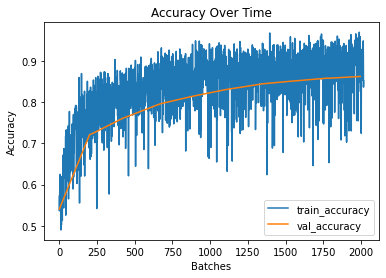

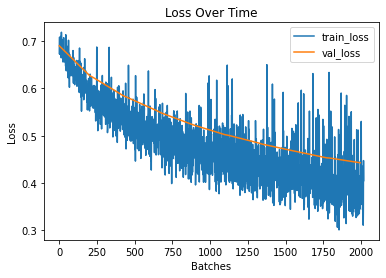

In [22]:
# Training/Validation Accuracy
a_train, b_train = zip(*accuracy_train)
a_val, b_val = zip(*accuracy_test_val)
plt.plot(a_train, b_train, label='train_accuracy')
plt.plot(a_val, b_val, label='val_accuracy')
plt.xlabel("Batches")
plt.ylabel("Accuracy")
plt.title("Accuracy Over Time")
plt.legend()
plt.show()
print()

# Training/Validation Loss
a_train, b_train = zip(*losses_train)
a_val, b_val = zip(*losses_test_val)
plt.plot(a_train, b_train, label='train_loss')
plt.plot(a_val, b_val, label='val_loss')
plt.xlabel("Batches")
plt.ylabel("Loss")
plt.title("Loss Over Time")
plt.legend()
plt.show()

**NOTE:**

Guessing that the pixel is not cancerous every single time will give you an accuracy of ~ 85%.
Your trained network should be able to do better than that (but you will not be graded on accuracy).
This is the result I got after 1 hour or training.

![](http://liftothers.org/dokuwiki/lib/exe/fetch.php?w=400&tok=d23e0b&media=cs501r_f2016:training_accuracy.png)
![](http://liftothers.org/dokuwiki/lib/exe/fetch.php?w=400&tok=bb8e3c&media=cs501r_f2016:training_loss.png)

___

### Part 3

Generate at least 5 predictions on the pos_test_000072.png image and display them as images. These predictions should be made at a reasonable interval (e.g. every epoch). 

To do this, calculate the output of your trained network on the pos_test_000072.png image,
then make a hard decision (cancerous/not-cancerous) for each pixel.
The resulting image should be black-and-white, where white pixels represent things
you think are probably cancerous.

**TODO:**

**DONE:**



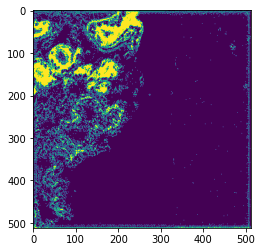

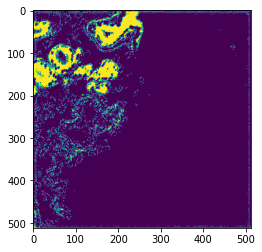

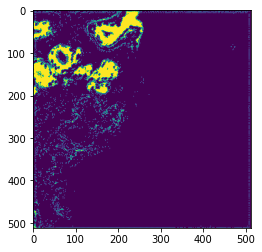

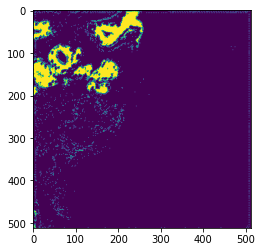

In [21]:
# NOTE: training took a crazy long time (probably due to google not giving me the fasted GPU due to a lot computing and debugging with this lab) ... so I was 
#       not able to tune my training loop precisely to get 5 images throughout my batches, I only able to print 4 images

for img in test_image_data_list:
  plt.imshow(img) 
  plt.imshow(img)
  plt.show()
  print()